In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

random_seed = 2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

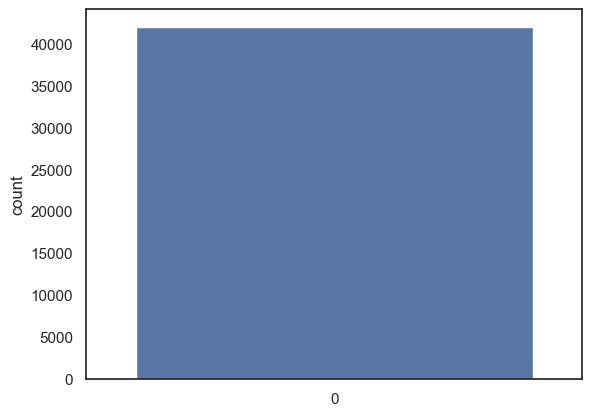

In [19]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 


g = sns.countplot(Y_train)

Y_train.value_counts()

Fixing if there are any null values

In [20]:
X_train.isnull().any().describe()
test.isnull().any().describe()

X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

Splitting Training and validation sets

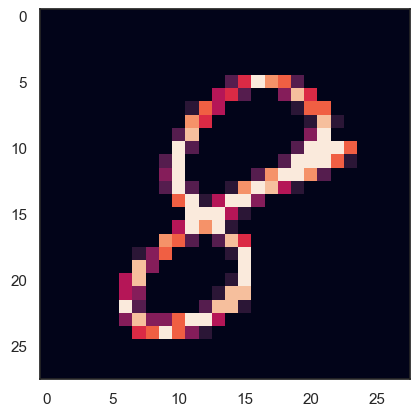

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
g = plt.imshow(X_train[0][:,:,0])

Implementing CNN

In [22]:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 1 
batch_size = 86

Data augmentation

In [23]:
datagen = ImageDataGenerator( featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,  
        samplewise_std_normalization=False, zca_whitening=False, rotation_range=10,  
        zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1,  
        horizontal_flip=False,vertical_flip=False) 


datagen.fit(X_train)

history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

439/439 - 113s - loss: 0.4341 - accuracy: 0.8591 - val_loss: 0.0658 - val_accuracy: 0.9805 - lr: 0.0010 - 113s/epoch - 258ms/step


Eval model

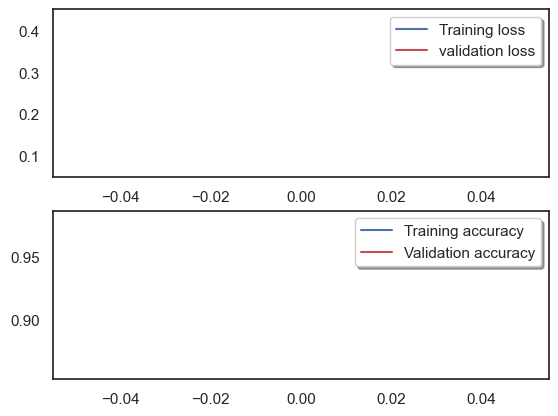

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Testing the validation set

875/875 [==============================] - 20s 23ms/step


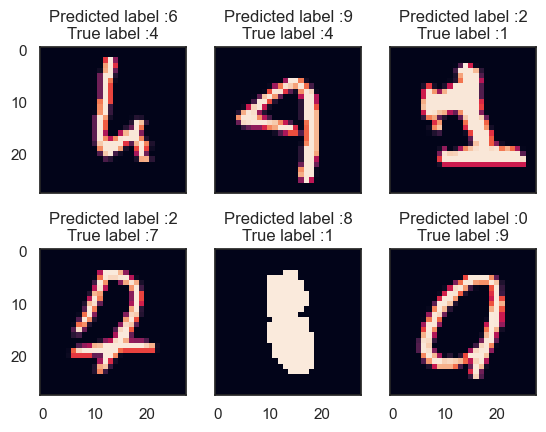

In [25]:
   
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1)

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
   
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))


delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors


sorted_dela_errors = np.argsort(delta_pred_true_errors)

most_important_errors = sorted_dela_errors[-6:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)